# inter-annual drivers of US east and Gulf Coast sea level

Goal: consolidate various interpretations of structure and drivers
* Valle-Levinson, McCarthy, Volkov, others link to NAO: sometimes a single signed mode south of Hatteras, sometimes anti-phase N/S. Others focus only on S of Hatteras but include NAO-linked wind stresses (Steinberg).
* Less emphasis on how Gulf coast participates.
* Wang papers have begun to definitively identify drivers using B+M experiments, but always in relatively coarse model. Haven’t looked at details of alongcoast structure.
* Leaves questions:
  * Is it a dipole, and what drives it?
  * How are path migrations related to the large scale forcings (Andres/Donatelli/Guo/Wu and He): does this related to DWBC/slope current involvement? What’s causal/correlated.
  * Does coherence arise from dynamics or forcing? Remote or local?
  * What's driving remaining variability?
  * How linked are offshore and onshore?
  * Resolution dependence
* Little 24/25 points to notable differences at high rez. Focusing on a higher frequency mode. Here we return to lower frequency variability. HR – allows coastal communication to be investigated in more detail.


## Import required packages, global parameters, functions

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
from scipy import signal
import scipy as sp
from scipy import io

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as xccrs
import cartopy.feature as cfeature
%matplotlib inline
import momlevel
import datetime as dt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from mypyutils import colormap_utils as mycolors
mdates.MonthLocator(bymonthday=15)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'serif',
    "font.serif": 'Computer Modern'
})    

cols=['k','C1','C0','C2','C3','C4','C5','C6']   
lines = ["-","--",":",":"]
panellabs=list(map(chr, range(97, 112)))
rotated_crs = xccrs.RotatedPole(pole_longitude=25.0, pole_latitude=70.0) # define projection!

In [2]:
import sys
sys.path.append("./../NSF-OCE_2148596/notebooks/pacific_HRDP_DPLE/lfca/Python")
from signal_processing import lfca

In [3]:
def tg_lfca(da, cutoff, truncation):
    lat_axis = da.tgindex.values
    time = da.time.values
    sst = da.to_numpy().squeeze()
    nlat = da.shape[1]
    ntime = da.shape[0]
    x = da.values
    area_weights = da[0, :] * 0 + 1
    area_weights = np.expand_dims(area_weights, axis=0)
    area_weights
    normvec = np.transpose(area_weights) / np.sum(area_weights)
    scale = np.sqrt(normvec)
    (
        lfcs,
        lfps,
        weights,
        r,
        pvar,
        pcs,
        eofs,
        ntr,
        pvar_slow,
        pvar_lfc,
        r_eofs,
        pvar_slow_eofs,
        lf_ts,
    ) = lfca(x, cutoff, truncation, scale)

    return lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts

In [4]:
def butter_bpfilt_high(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1], fs=fs, btype='high')
    return signal.filtfilt(b, a, x)
    
def butter_bpfilt_band(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1, fc2], fs=fs, btype='band')
    return signal.filtfilt(b, a, x)
    
def butter_bpfilt_low(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1], fs=fs, btype='low')
    return signal.filtfilt(b, a, x)
    
def filtfilt_bpbutter_2d_low(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_low,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["tgindex","time"], [], [], [], []],  # regrid
        output_core_dims=[["tgindex","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt    

def filtfilt_bpbutter_3d_low(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_low,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["lat","lon","time"], [], [], [], []],  # regrid
        output_core_dims=[["lat","lon","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt

In [5]:
def detrend_linear2(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:,:]

def detrend_linear_tg(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:]
    
def detrend_deseason(da): #order/fs/low pass filter unused so far
    [fosi_det, fosi_trend]=detrend_linear2(da, 'time')
    fosi_trend=fosi_trend * 1e9  * 60  * 60  * 24 * 365
    fosi_mean_sea=fosi_det.groupby("time.month").mean("time")
    # fosi_desea=fosi_det.groupby("time.month")-fosi_mean_sea
    fosi_desea=da.groupby("time.month")-fosi_mean_sea
    return fosi_desea.drop_vars('month'), fosi_trend

In [6]:
#processing functions

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    # print(x)

    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)
    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
        
    # print(x)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    # print(x,y)
    n     = x.shape[0]
    xmean = x.mean(axis=0, skipna=False)
    ymean = y.mean(axis=0, skipna=False)
    xstd  = x.std(axis=0, skipna=False)
    ystd  = y.std(axis=0, skipna=False)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    # pval   = t.sf(tstats, n-2)*2
    pval = t.sf(abs(tstats), n-2)*2 #corrected
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

## Import processed TGs and ALPACA output

In [7]:
tgs_in=pd.read_pickle("tgs_in_93_22.pkl") ##detrended
tgcsvin="./tgs_in_93_22.csv" #need to read in from csv for momlevel
tgnames=tgs_in['name2'].str.replace(r"\(.*\)","").str.replace(r"\,.*","").str.replace(r"\-.*","").str.replace(r"\/.*","").str.title()
shortname=tgnames.str.split('(').str[0]
shortname=shortname.str.split(',').str[0]
shortname

name
497        Port Isabel
538           Rockport
526         Grand Isle
161       Galveston Ii
1193      Apalachicola
246          Pensacola
520     St. Petersburg
188           Key West
395       Fort Pulaski
234       Charleston I
396         Wilmington
2295          Beaufort
299      Sewells Point
1295      Cambridge Ii
1153          Cape May
12           New York 
351            Newport
183         Portland  
Name: name2, dtype: object

In [8]:
xr_tg=xr.open_dataset('/glade/work/clittle/p2679/tgs_usec_93_22.nc') 
hr_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_tgs_det.nc')
hr_m_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_tgs_m-r_det.nc')
hr_b_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_hr_ssh_tgs_b_det.nc')
lr_tg=xr.open_dataset('/glade/derecho/scratch/clittle/alpaca_lr_ssh_tgs_det.nc')

xr_tg=xr_tg.ssh
hr_tg=hr_tg.ssh-hr_tg.ssh.mean(dim='time')
hr_tg['time']=xr_tg.time
hr_m_tg=hr_m_tg.ssh-hr_m_tg.ssh.mean(dim='time')
hr_m_tg['time']=xr_tg.time
hr_b_tg=hr_b_tg.ssh-hr_b_tg.ssh.mean(dim='time')
hr_b_tg['time']=xr_tg.time
lr_tg=lr_tg.ssh-lr_tg.ssh.mean(dim='time')
lr_tg['time']=xr_tg.time
hr_tg=hr_tg.T
hr_b_tg=hr_b_tg.T
hr_m_tg=hr_m_tg.T
lr_tg=lr_tg.T

## Coastal/TG timeseries comparisons

/glade/derecho/scratch/clittle/tmp/ipykernel_96349/3695442294.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]


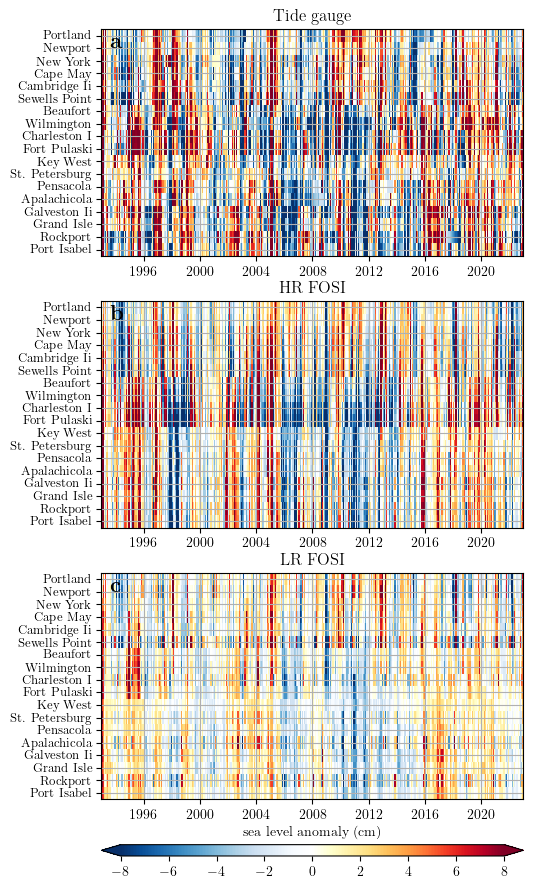

In [9]:
fig = plt.figure(figsize=(14,10))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
# cmap='Spectral_r'
ylabspacing = 1

vmin = -8
vmax2 = -vmin

for nsim in np.arange(3):
    if nsim<1:
        plotvar=xr_tg
        titstr="Tide gauge"
    else:
        if nsim<2:
            plotvar=hr_tg
            titstr="HR FOSI"
        else:
            plotvar=lr_tg
            titstr="LR FOSI"

    ax1 = plt.subplot2grid((3,5), (nsim, 1), colspan=2, rowspan=1)

    filled1 = ax1.pcolormesh(
        xr_tg.time,
        np.arange(0, len(tgnames), 1),
        plotvar.T,
        vmin=vmin,
        vmax=vmax2,
        cmap=cmap,
        shading="nearest",
    )
    plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
# labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
# ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
    ticks = np.arange(0, len(tgnames), ylabspacing)
    if nsim<5:
        labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
    else:
        labels = []
    ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    plt.title(titstr)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    pos = ax1.get_position()  # get the original position
    
    if nsim>1:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
        )
        cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
        cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
        cbar.ax.tick_params(labelsize=10)

/glade/derecho/scratch/clittle/tmp/ipykernel_96349/2725563618.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_96349/2725563618.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]


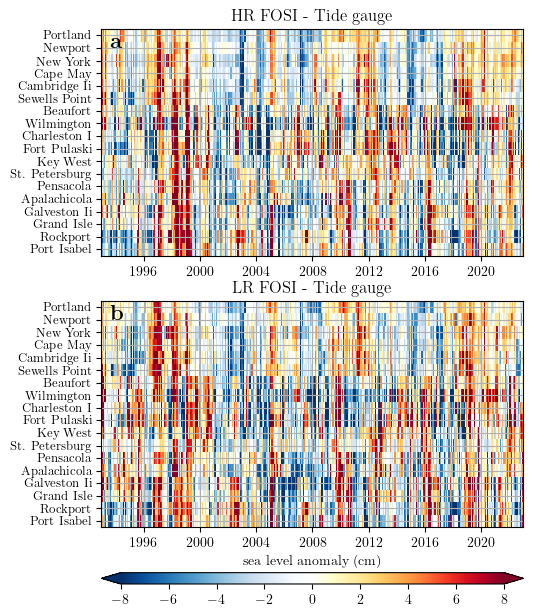

In [10]:
fig = plt.figure(figsize=(14,10))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
# cmap='Spectral_r'
ylabspacing = 1

vmin = -8
vmax2 = -vmin

for nsim in np.arange(2):
    if nsim<1:
        plotvar=xr_tg-hr_tg
        titstr="HR FOSI - Tide gauge"
    else:
        if nsim<2:
            plotvar=xr_tg-lr_tg
            titstr="LR FOSI - Tide gauge"
        else:
            plotvar=lr_tg
            titstr="LR FOSI"

    ax1 = plt.subplot2grid((3,5), (nsim, 1), colspan=2, rowspan=1)

    filled1 = ax1.pcolormesh(
        xr_tg.time,
        np.arange(0, len(tgnames), 1),
        plotvar.T,
        vmin=vmin,
        vmax=vmax2,
        cmap=cmap,
        shading="nearest",
    )
    plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
# labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
# ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
    ticks = np.arange(0, len(tgnames), ylabspacing)
    if nsim<5:
        labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
    else:
        labels = []
    ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    plt.title(titstr)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    pos = ax1.get_position()  # get the original position
    
    if nsim>0:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
        )
        cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
        cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
        cbar.ax.tick_params(labelsize=10)

## Calculate EOFs/LFCAs and define plot fxns

In [11]:
kwargs = dict(n_modes=len(xr_tg.T)-1,random_state=2)#, normalize=True)
expvar_eofs=[]
expvar_lfcs=[]
pcs=[]
eofs=[]
rec_eof_ts=[]
rec_lfp_ts=[]
lfcs=[]
lfps=[]
phases=[]
# real_ts=[]
cuts=[12,24,36]
cutoff=cuts[1]
truncation=3
nmodes=3
rec_eof=np.tile(xr_tg.values[np.newaxis,:, :]*0, [nmodes,1,1])
rec_lfp=np.tile(xr_tg.values[np.newaxis,:, :]*0, [nmodes,1,1])

for nsim in np.arange(2):
    if nsim<1:
        dain=xr_tg
    else:
        if nsim<2:
            dain=hr_tg
        else:
            dain=lr_tg
            
    lfc, lfp, weights, r, pvar, pc, eof, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(dain, cutoff, truncation)
    expvar_lfc = pvar_slow #fraction of total SSH variance
    # lfp=lfp[np.argsort(-expvar_lfc),:]
    # lfc=lfc[:,np.argsort(-expvar_lfc)]
    # expvar_lfc=expvar_lfc[np.argsort(-expvar_lfc)]
    expvar_eof = pvar
    
    for nmode in np.arange(nmodes):
        rec_eof[nmode,:,:]=np.outer(pc[:,nmode],eof[nmode,:])
        rec_lfp[nmode,:,:]=np.outer(lfc[:,nmode],lfp[nmode,:])
        
    expvar_eofs.append(expvar_eof)
    expvar_lfcs.append(expvar_lfc)
    # real_ts.append(dain)
    pcs.append(pc)
    lfcs.append(lfc)
    eofs.append(eof)
    lfps.append(lfp)
    rec_eof_ts.append(rec_eof)
    rec_lfp_ts.append(rec_lfp)

In [12]:
def plot_obs_pcs(tgpcs,eofsin,expvar,recs,vmaxin, varscale):
    fig = plt.figure(figsize=(10,13))#, tight_layout=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    nsim=0
    cmap = 'plasma'
    cmap = mycolors.blue2red_cmap(20)
    tot_var=xr_tg.var(dim='time')    
    rec_var=recs[0].std(axis=1)
    ylabspacing = 2
    
    vmin = -vmaxin
    vmax = -vmin

    for nmode in np.arange(3):
        ax = plt.subplot2grid((5,3), (2, nmode), colspan=1, rowspan=2, projection=rotated_crs)#, aspect="auto")
        pos = ax.get_position() # get the original position 

        # if nmode<1:    
        #     VE=recs_m1[nsim].var(dim='time')/tot_var
        # else:
        #     if nmode<2:    
        #         VE=recs_m2[nsim].var(dim='time')/tot_var
        #     else:
        #         VE=recs_m3[nsim].var(dim='time')/tot_var
                
        filled1 = plt.scatter(
            x=tgs_in.lon,
            y=tgs_in.lat,
            vmin=vmin,
            vmax=vmax,
            c=eofsin[nsim][nmode,:],
            cmap=cmap,  # this is the changes
            s=varscale*rec_var[nmode,:],
            alpha=1,
            edgecolors="k",
            linewidth=1,
            # marker=None,
            zorder=7,
            transform=xccrs.PlateCarree(),
        )  ## Important
        
        # for nkey in np.arange(2):
        #     varval=varscale*(.25+.5*nkey)**1.5
            
        #     varkey = plt.scatter(
        #         x=tgs_in.lon,
        #         y=tgs_in.lat,
        #         vmin=vmin,
        #         vmax=vmax,
        #         c=amps[nsim][nmode,:],
        #         cmap=cmap,  # this is the changes
        #         s=varval,
        #         alpha=1,
        #         edgecolors=".6",
        #         linewidth=1,
        #         # marker=None,
        #         zorder=7,
        #         transform=xccrs.PlateCarree(),
        #     )  ## Important
            
        #     varkey.set_facecolor("none")   
        
        ax.set_extent([-90, -78, 20, 48], crs=xccrs.PlateCarree())        
        ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
        ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
        ax.add_feature(cfeature.LAKES,zorder=3)

        ax.coastlines(zorder=5)
        ax.gridlines()

        if nmode<1:
            cbar_ax = fig.add_axes(
                [pos.x0+(pos.x1 - pos.x0)/4, pos.y0+(pos.y1 - pos.y0)/4, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
            )
            cbar = fig.colorbar(filled1, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
            cbar.ax.set_title("EOF (cm/SD)", rotation=0, size=10, weight="bold")
            cbar.ax.tick_params(labelsize=10)
                
        # ax.text(.02,.95, 'PC' + str(nsp+1) + ' lags by ' + str(lagx) + ' months' , transform=ax.transAxes, fontsize=12, weight='bold')
        # plt.figtext(-110,-40, "LF VE. = {:.0}".format(VE[nsp]), horizontalalignment='right', verticalalignment='center', fontsize=16, transform=ax.transAxes)
        # plt.figtext(0.02, .95, r"$\bf{" + panellabs[nmode] + '' "}$" + 'EOF'+str(nmode+1), horizontalalignment='left', 
        plt.figtext(0.02, .95, r"$\bf{" + panellabs[nmode] + '' "}$" + '', horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=12, transform=ax.transAxes)
        plt.figtext(0.02, .04, ''+'{0:.0f}'.format(expvar[nsim][nmode])+"\%", horizontalalignment='left', 
                verticalalignment='bottom', fontsize=12, transform=ax.transAxes)
    import matplotlib.dates as mdates
    ax = plt.subplot2grid((5,3), (4,0), colspan=3, rowspan=1)    
    for nsp in np.arange(2):
        line = ax.plot(xr_tg.time,tgpcs[nsim][:,nsp],cols[nsp], label = 'data')
    plt.grid()
    plt.ylabel('Normalized PC')
    ax.legend([],     # The line objects
           labels=["TG PC1","TG PC2"],   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.4,    # Small spacing around legend box
           title="",
           fontsize=12,# Title for the legend
             )
    plt.figtext(0.02, .86, r"$\bf{" + panellabs[3] + '' "}$", horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=12, transform=ax.transAxes)



In [13]:
def plot_hr_pcs(tgpcs,eofsin,expvar,recs,vmaxin, varscale):
    fig = plt.figure(figsize=(10,13))#, tight_layout=True)
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    nsim=1
    cmap = 'plasma'
    cmap = mycolors.blue2red_cmap(20)
    tot_var=xr_tg.var(dim='time')    
    rec_var=recs[1].std(axis=1)
    ylabspacing = 2
    
    vmin = -vmaxin
    vmax = -vmin

    for nmode in np.arange(3):
        ax = plt.subplot2grid((5,3), (2, nmode), colspan=1, rowspan=2, projection=rotated_crs)#, aspect="auto")
        pos = ax.get_position() # get the original position 

        # if nmode<1:    
        #     VE=recs_m1[nsim].var(dim='time')/tot_var
        # else:
        #     if nmode<2:    
        #         VE=recs_m2[nsim].var(dim='time')/tot_var
        #     else:
        #         VE=recs_m3[nsim].var(dim='time')/tot_var
                
        filled1 = plt.scatter(
            x=tgs_in.lon,
            y=tgs_in.lat,
            vmin=vmin,
            vmax=vmax,
            c=eofsin[nsim][nmode,:],
            cmap=cmap,  # this is the changes
            s=varscale*rec_var[nmode,:],
            alpha=1,
            edgecolors="k",
            linewidth=1,
            # marker=None,
            zorder=7,
            transform=xccrs.PlateCarree(),
        )  ## Important
        
        # for nkey in np.arange(2):
        #     varval=varscale*(.25+.5*nkey)**1.5
            
        #     varkey = plt.scatter(
        #         x=tgs_in.lon,
        #         y=tgs_in.lat,
        #         vmin=vmin,
        #         vmax=vmax,
        #         c=amps[nsim][nmode,:],
        #         cmap=cmap,  # this is the changes
        #         s=varval,
        #         alpha=1,
        #         edgecolors=".6",
        #         linewidth=1,
        #         # marker=None,
        #         zorder=7,
        #         transform=xccrs.PlateCarree(),
        #     )  ## Important
            
        #     varkey.set_facecolor("none")   
        
        ax.set_extent([-90, -78, 20, 48], crs=xccrs.PlateCarree())        
        ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
        ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
        ax.add_feature(cfeature.LAKES,zorder=3)

        ax.coastlines(zorder=5)
        ax.gridlines()

        if nmode<1:
            cbar_ax = fig.add_axes(
                [pos.x0+(pos.x1 - pos.x0)/4, pos.y0+(pos.y1 - pos.y0)/4, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
            )
            cbar = fig.colorbar(filled1, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
            cbar.ax.set_title("EOF (cm/SD)", rotation=0, size=10, weight="bold")
            cbar.ax.tick_params(labelsize=10)
                
        # ax.text(.02,.95, 'PC' + str(nsp+1) + ' lags by ' + str(lagx) + ' months' , transform=ax.transAxes, fontsize=12, weight='bold')
        # plt.figtext(-110,-40, "LF VE. = {:.0}".format(VE[nsp]), horizontalalignment='right', verticalalignment='center', fontsize=16, transform=ax.transAxes)
        # plt.figtext(0.02, .95, r"$\bf{" + panellabs[nmode] + '' "}$" + 'EOF'+str(nmode+1), horizontalalignment='left', 
        plt.figtext(0.02, .95, r"$\bf{" + panellabs[nmode] + '' "}$" + '', horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=12, transform=ax.transAxes)
        plt.figtext(0.02, .04, ''+'{0:.0f}'.format(expvar[nsim][nmode])+"\%", horizontalalignment='left', 
                verticalalignment='bottom', fontsize=12, transform=ax.transAxes)
    import matplotlib.dates as mdates
    ax = plt.subplot2grid((5,3), (4,0), colspan=3, rowspan=1)    
    for nsp in np.arange(2):
        line = ax.plot(xr_tg.time,tgpcs[nsim][:,nsp],cols[nsp], label = 'data')
    plt.grid()
    plt.ylabel('Normalized PC')
    ax.legend([],     # The line objects
           labels=["HR PC1","HR PC2"],   # The labels for each line
           loc="upper right",   # Position of legend
           borderaxespad=0.4,    # Small spacing around legend box
           title="",
           fontsize=12,# Title for the legend
             )
    plt.figtext(0.02, .86, r"$\bf{" + panellabs[3] + '' "}$", horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=12, transform=ax.transAxes)



## TG EOF

/glade/derecho/scratch/clittle/tmp/ipykernel_125549/469522519.py:93: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


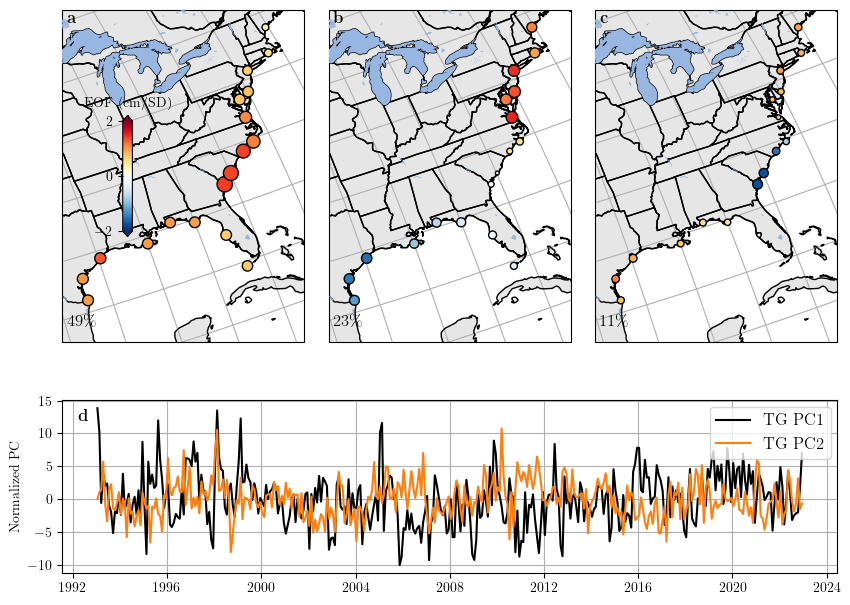

In [30]:
plot_obs_pcs(pcs,eofs,expvar_eofs,rec_eof_ts,2, 20)#amps[nsim][0:2,:].max())
# plt.savefig('s4.png',
# )

## HR EOF

/glade/derecho/scratch/clittle/tmp/ipykernel_96349/3255632951.py:93: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


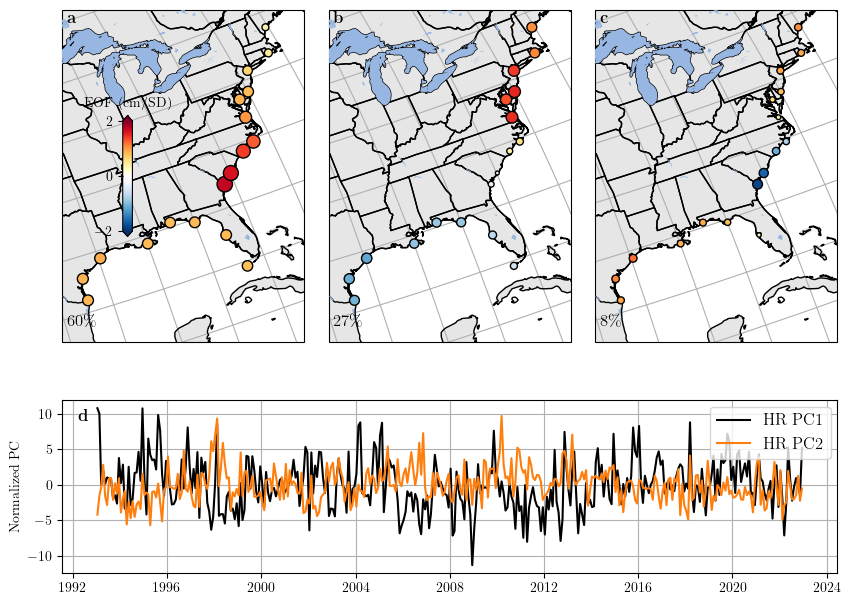

In [14]:
plot_hr_pcs(pcs,eofs,expvar_eofs,rec_eof_ts,2, 20)#amps[nsim][0:2,:].max())
# plt.savefig('s4.png',
# )

* Pretty similar in models and obs
* EOF1 -- See Little et al. GRL analysis: Looks like mode 1, with a smaller amplitude in Gulf than SAB.
<!-- * note that this is predominantly less than a year. -->
* More variance in Mode 1 in HR relative to obs.
* Note lower frequencies in Mode 2/3.
* Add TG-HR correlations?

## TG 2-yr filtered (~LFCA)

/glade/derecho/scratch/clittle/tmp/ipykernel_125549/469522519.py:93: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


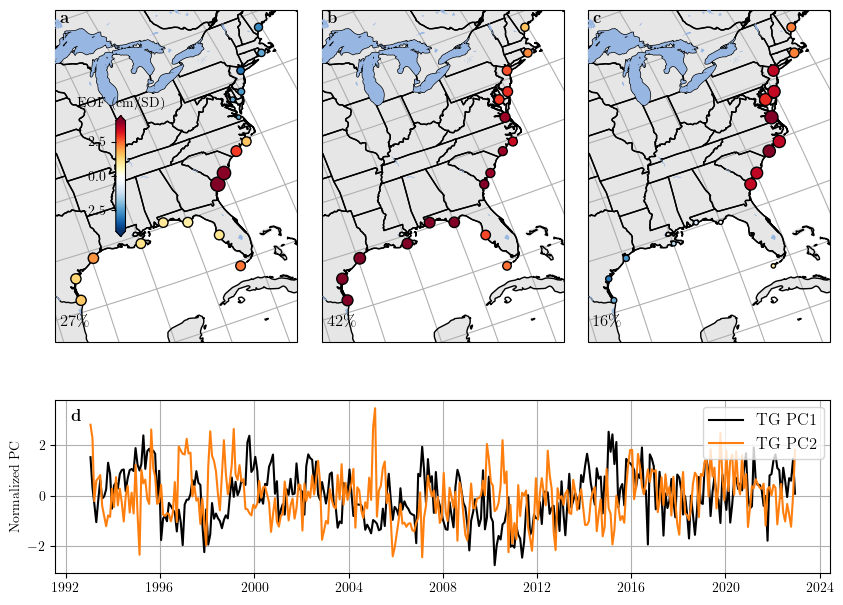

In [32]:
plot_obs_pcs(lfcs,lfps,expvar_lfcs,rec_lfp_ts,4, 20)#amps[nsim][0:2,:].max())
# plt.savefig('s4.png',
# )

* Ranked by ratio of variance in >2 years relative to total variance (shown in corner)
* three modes of variability all contribute meaningfully to interannual variance (common/NAO/EC dipole)
  * These differ from monthly EOFs, but are insensitivie to filtering after ~6-12 months
* Dipole more important fractionally at low frequency, but common remain important.
  * Splitting into a common mode and a non-Gulf mode (2/3)
* Each mode raises dynamical questions:
* Mode 1: Alongcoast dipole implies either there's a source from offshore at Cape Hatteras, or a compensation of coastal shelf signal in the north. (Minobe/Wise frameworks)
  * Mode 1/2: Some source of connectivity to Gulf: wave propagation or common forcing, and if so what? Why is it not there for mode 3? Why do the relative magnitude of EC/GC differ across modes?

## HR 2-yr filtered (~LFCA)

/glade/derecho/scratch/clittle/tmp/ipykernel_96349/3255632951.py:93: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend([],     # The line objects


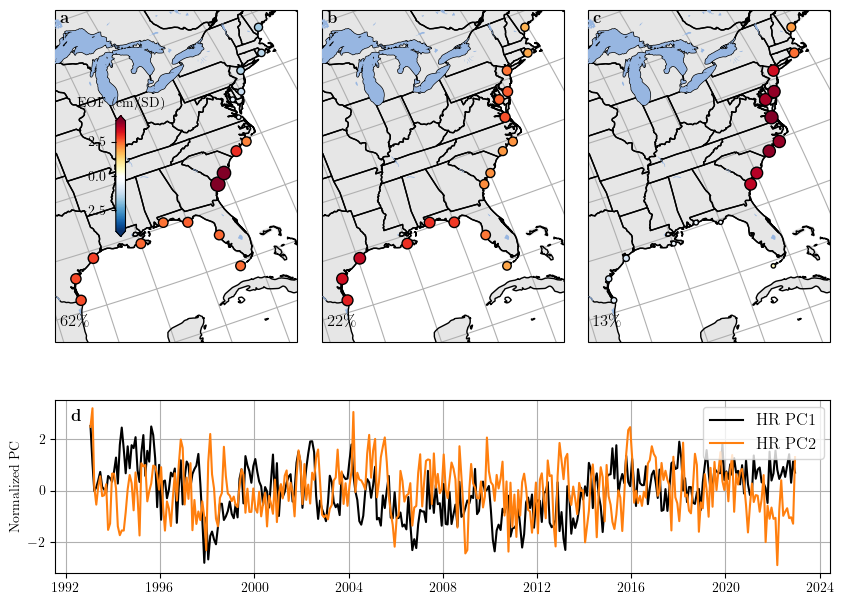

In [15]:
plot_hr_pcs(lfcs,lfps,expvar_lfcs,rec_lfp_ts,4, 20)#amps[nsim][0:2,:].max())
# plt.savefig('s4.png',
# )

In [36]:
# compare one mode, then show corr coefs between HR and TG
for nmode in np.arange(3):
    cc=np.corrcoef(lfcs[0][:,nmode],lfcs[1][:,nmode])
    print('Mode' + str(nmode+1) + ' corr coef = ' + str(cc[1,0]))
# lfcs[0].shape

Mode1 corr coef = 0.6584196801804201
Mode2 corr coef = 0.6692573676833391
Mode3 corr coef = 0.726329815142227


* Strong Model/Obs similarity across all modes
* too much fractional variance in dipole mode (mode 1) in HR (weak common variability?)
* Somewhat weaker expression N of hatteras in mode 1 (EOF splitting or weak)?

[51.46140939 28.63546614 16.50459443]
[62.22271272 22.0247702  13.20280136]
[70.03181477 12.50600484 14.82153237]


/glade/derecho/scratch/clittle/tmp/ipykernel_96349/4040411314.py:16: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([],     # The line objects


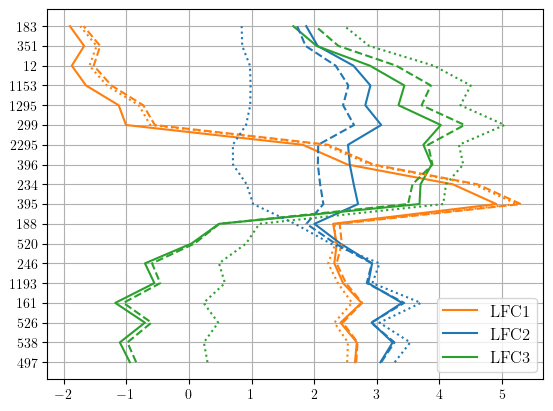

In [18]:
#sensitivity to lowpass filter
for nsens in np.arange(3):
    cuts=[12,24,36]
    cutoff=cuts[nsens]
    truncation=3
    lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(hr_tg, cutoff, truncation)
    for nmode in np.arange(3):
        if lfps[nmode,9]<0:
            lfps[nmode,:]=-lfps[nmode,:]
        plt.plot(lfps[nmode,:],xr_tg.tgindex,color=cols[nmode+1],linestyle=lines[nsens])
        
    # print(pvar)
    print(pvar_slow[0:3])
    # print(pvar_lfc[0:3])
plt.grid()
plt.legend([],     # The line objects
       labels=["LFC1","LFC2","LFC3"],   # The labels for each line
       loc="lower right",   # Position of legend
       borderaxespad=0.4,    # Small spacing around legend box
       title="",
       fontsize=12,# Title for the legend
         )
# tgftot1950_gmrem

* Limited sensitivity to filter length for modes 1/3, some for mode 2

/glade/derecho/scratch/clittle/tmp/ipykernel_96349/1870596450.py:24: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([],     # The line objects


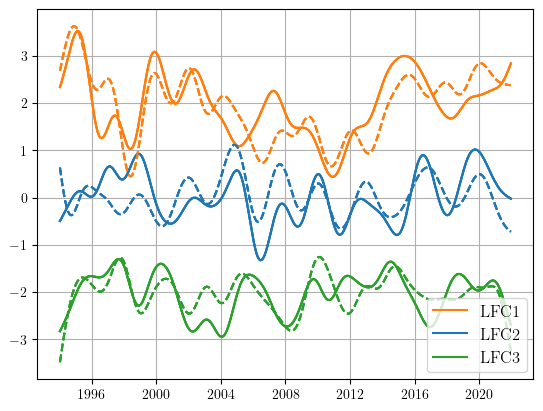

In [19]:
for nsens in np.arange(3):
    cutoff=cuts[1]
    for nsens in np.arange(2):
        if nsens<1:
            lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(xr_tg, cutoff, truncation)
        else:
            if nsens<2:
                lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(hr_tg, cutoff, truncation)
            else:
                lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(lr_tg, cutoff, truncation)
        for nmode in np.arange(3):
            if lfps[nmode,0]<0:
                lfps[nmode,:]=-lfps[nmode,:]
                lfcs[nmode,:]=-lfcs[nmode,:]
            if nmode<1:
                plt.plot(xr_tg.time[int(cutoff/2):int(-cutoff/2)],butter_bpfilt_low(lfcs[int(cutoff/2):int(-cutoff/2),0],1/24,0,1,5)+2,color=cols[0+1],linestyle=lines[nsens])
            else:
                if nmode<2:
                    plt.plot(xr_tg.time[int(cutoff/2):int(-cutoff/2)],butter_bpfilt_low(lfcs[int(cutoff/2):int(-cutoff/2),1],1/24,0,1,5),color=cols[0+2],linestyle=lines[nsens])
                else:
                    plt.plot(xr_tg.time[int(cutoff/2):int(-cutoff/2)],butter_bpfilt_low(lfcs[int(cutoff/2):int(-cutoff/2),2],1/24,0,1,5)-2,color=cols[0+3],linestyle=lines[nsens])
        # print(pvar_slow)
plt.grid()
plt.legend([],     # The line objects
       labels=["LFC1","LFC2","LFC3"],   # The labels for each line
       loc="lower right",   # Position of legend
       borderaxespad=0.4,    # Small spacing around legend box
       title="",
       fontsize=12,# Title for the legend
         )

* Context for 2010-2020 event: in mode 1 with some amplification from Mode 2?

In [38]:
# for nmode in np.arange(3):
#     lfcs[:,nmode]=butter_bpfilt_low(lfcs[:,nmode],1/cutoff,0,1,5)
# lfcs=lfcs[int(cutoff/2):int(-cutoff/2),:]

In [39]:
def plot_ssh_reg(tgpcs,SSH,tglons,tglats, coast_reg=True):
    fig = plt.figure(figsize=(12,6), tight_layout=True)
    vmin=-6
    vmax=-vmin
    
    cmap = mycolors.blue2red_cmap(20)
    
    for nsp in np.arange(3):
        for nsim in np.arange(1):
            lagx=0
            lons=tglons
            lats=tglats 
            tgpcs=tgpcs
            regressand=SSH 
            # regressand2=xr_tg.TG_IB_CORR
                    
            focusts=regressand[:,0,0].fillna(0)*0+np.real(tgpcs[nsp,:])
            cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(x=focusts,y=regressand, lagx=lagx)
            altrc=slope+regressand[0,:,:]*0
            altpval=pval
            mask=1+0/(pval<pvalc)
            # focusts=regressand2.isel(tgindex=0).squeeze()*0+np.real(tgpcs[nsp,:])
            # cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(x=focusts,y=regressand2, lagx=lagx)
            
            ax = plt.subplot2grid((1,3), (0, nsp), colspan=1, rowspan=1, projection=xccrs.PlateCarree())#, aspect="auto")
            
            pos = ax.get_position() # get the original position 
            if coast_reg:
                ax.set_extent([-100, -60, 20, 52], crs=xccrs.PlateCarree())
            else:
                ax.set_extent([-100, 0, 10, 70], crs=xccrs.PlateCarree())
            im = ax.pcolormesh(lons, lats, mask*altrc, shading='nearest', vmin=vmin, vmax=vmax, 
            # im = ax.pcolormesh(lons, lats, altrc, shading='nearest', vmin=vmin, vmax=vmax, 
                        cmap=cmap,zorder=1,transform=xccrs.PlateCarree())    

            CS2 = ax.contour(ds_bathy.depth.longitude ,ds_bathy.depth.latitude, -ds_bathy.depth,
                            np.arange(100,101,1),colors='.6',linewidths=2,zorder=2,transform=xccrs.PlateCarree())
            
            CS2 = ax.contour(ds_bathy.depth.longitude ,ds_bathy.depth.latitude, -ds_bathy.depth,
                           np.arange(1000,2000,1000),colors='.6',linewidths=1,zorder=2,transform=xccrs.PlateCarree())

            if nsp==0:
                cbar_ax = fig.add_axes(
                    [pos.x1-(pos.x1 - pos.x0)/10, pos.y0+(pos.y1 - pos.y0)/10, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
                )
                cbar = fig.colorbar(im, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
                # cbar.ax.set_title("Reg. Coef. on PC" + str(nmode+1), rotation=0, size=10, weight="bold")
                cbar.ax.tick_params(labelsize=10)
                
            # if nsim<1:
            #     plt.figtext(.05, .95, 'Regression on HR PC'+str(nsp+1), horizontalalignment='left', verticalalignment='center', fontsize=20, transform=ax.transAxes)
            # else:
            #     plt.figtext(.05, .95, 'Regression on LR PC'+str(nsp+1), horizontalalignment='left', verticalalignment='center', fontsize=20, transform=ax.transAxes)
                            
            ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
            # ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
    
            ax.coastlines(zorder=5)
            ax.gridlines()
            # ax.text(.02,.95, 'PC' + str(nsp+1) + ' lags by ' + str(lagx) + ' months' , transform=ax.transAxes, fontsize=12, weight='bold')
    # return altrc

## Altimetry analysis

In [53]:
datadir = '/glade/work/clittle/altimetry/MEASURES/monthly/'
alt=xr.open_mfdataset(datadir+'monthly*.nc')
alt=alt*100

In [54]:
alt=alt.rename({'Time': 'time','Longitude':'lon','Lon_bounds':'lon_b','Latitude':'lat','Lat_bounds':'lat_b'})
alt = alt.drop(['lon_b','lat_b'])
ds_alt=alt.sel(time=slice('1992-01-01', '2023-01-01'))

/glade/derecho/scratch/clittle/tmp/ipykernel_125549/2505444263.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  alt = alt.drop(['lon_b','lat_b'])


In [55]:
gmsl = xr.open_dataset("../NSF-OCE_2148596/notebooks/USEC_FOSI_rez_comp/gmsl_mo.nc")
gmsl=gmsl.sel(time=slice('1992-01-01', '2023-01-01'))#,Longitude=slice(xlo,xhi),Latitude=slice(ylo,yhi))
# gmsl_df=gmsl.to_pandas()/10
gmsl=gmsl.gmsl_variation/10

In [56]:
xlo=1550; xhi=2200; ylo=550; yhi=900;
# xlo=1550; xhi=1800; ylo=600; yhi=800;
da=ds_alt.SLA-gmsl
da=da.isel(lon=slice(xlo,xhi),lat=slice(ylo,yhi))#.sel(time=slice('1993-01-01','2019-1-1'))
# da=da.isel(time=slice(edgevals,-edgevals))

In [57]:
da['time']=xr_tg.time

In [59]:
[da, datrend]=detrend_deseason(da.load())

In [60]:
pvalc=.05
ds_bathy = xr.open_dataset('/glade/work/clittle/p2521/input/'+"/obs/GEBCO.nc")
# ds_bathy.depth

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


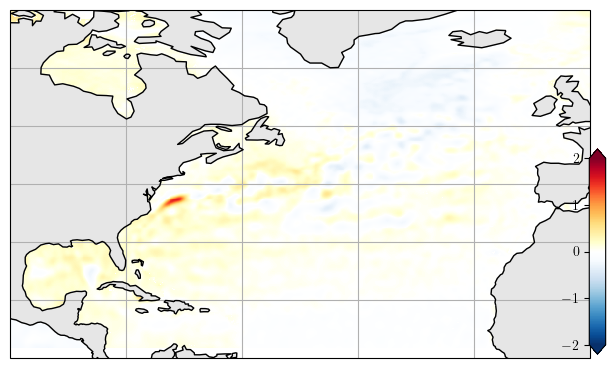

In [61]:
#altimetry trends
fig = plt.figure(figsize=(18,12), tight_layout=True)
vmin=-2
vmax=-vmin
cmap = mycolors.blue2red_cmap(20)

ax = plt.subplot2grid((1,3), (0, 0), colspan=1, rowspan=1, projection=xccrs.PlateCarree())#, aspect="auto")

pos = ax.get_position() # get the original position 
ax.set_extent([-100, 0, 10, 70], crs=xccrs.PlateCarree())
im = ax.pcolormesh(da.lon,da.lat,datrend, shading='nearest', vmin=vmin, vmax=vmax, 
# im = ax.pcolormesh(lons, lats, altrc, shading='nearest', vmin=vmin, vmax=vmax, 
            cmap=cmap,zorder=1,transform=xccrs.PlateCarree())    
cbar_ax = fig.add_axes(
    [pos.x1-(pos.x1 - pos.x0)/10, pos.y0+(pos.y1 - pos.y0)/10, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
)
cbar = fig.colorbar(im, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
# cbar.ax.set_title("Reg. Coef. on PC" + str(nmode+1), rotation=0, size=10, weight="bold")
cbar.ax.tick_params(labelsize=10)
ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
# ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
ax.coastlines(zorder=5)
ax.gridlines()

* Aside from main analysis: Is the altimeter trend aliasing the recent SEUS rise and the GS path? Or is that a lower-frequency element?

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


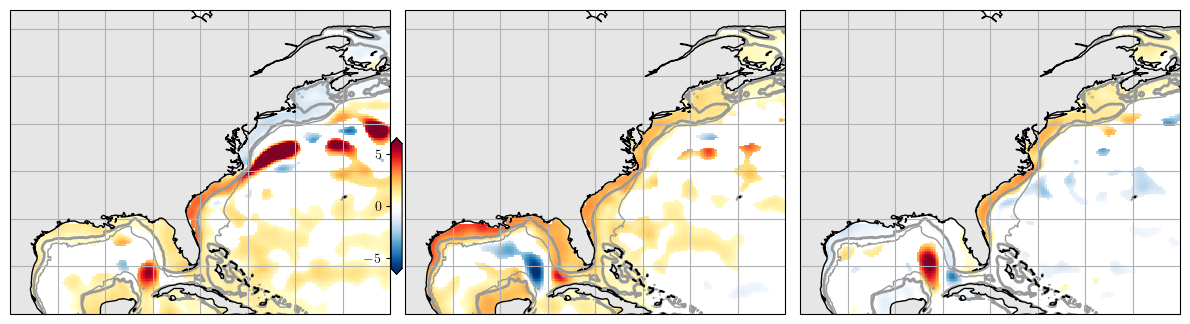

In [62]:
#detrend unfiltered
plot_ssh_reg(lfcs[0].T,da,da.lon,da.lat, True)

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


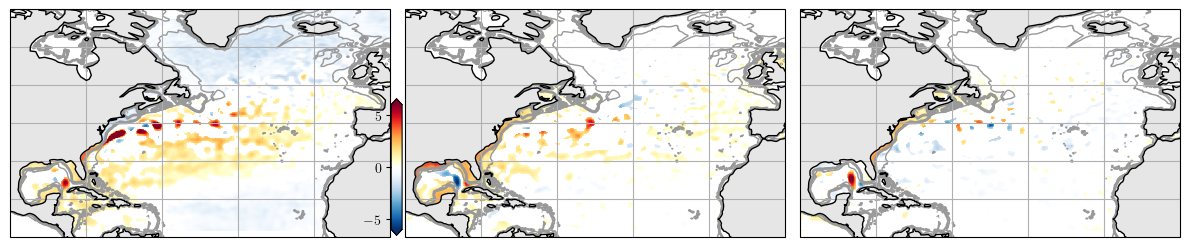

In [63]:
plot_ssh_reg(lfcs[0].T,da,da.lon,da.lat, False)

* Only mode 1 assocaited with basin interior variability
* * Mode 2 and 3 shelf-focused
* Dipole mode associated with GS displacement and clearer involvement of entire basin
* Loop current involvement?

## Regression of full simulation modes on unfiltered SSH

In [336]:
pvalc=.05

ds_bathy = xr.open_dataset('/glade/work/clittle/p2521/input/'+"/obs/GEBCO.nc")
# ds_bathy.depth

In [337]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_det.nc')
da=ssh.ssh#.isel(time=slice(edgevals,-edgevals))
##bandpass

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


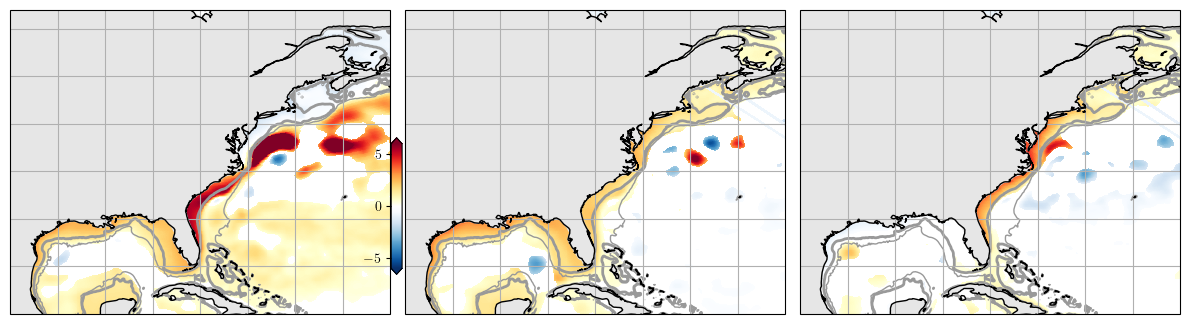

In [338]:
#detrend unfiltered
# da['time']=pcs[1].time
plot_ssh_reg(lfcs[1].T,da,da.TLONG.fillna(0),da.TLAT.fillna(0))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


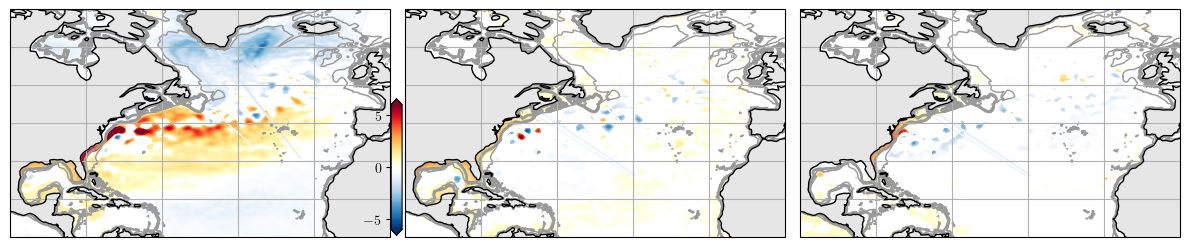

In [31]:
# da['time']=pcs[1].time
plot_ssh_reg(lfcs[1].T,da,da.TLONG.fillna(0),da.TLAT.fillna(0),False)

* pretty similar to obs! -- weaker mode 1 north of CH, consistent with LFCAs
* little bit of GS detachment in mode 3?

## Regression of full simulation modes on Momentum-forced SSH

In [339]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_m-r_det.nc')
da=ssh.ssh#.isel(time=slice(edgevals,-edgevals))
##bandpass

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


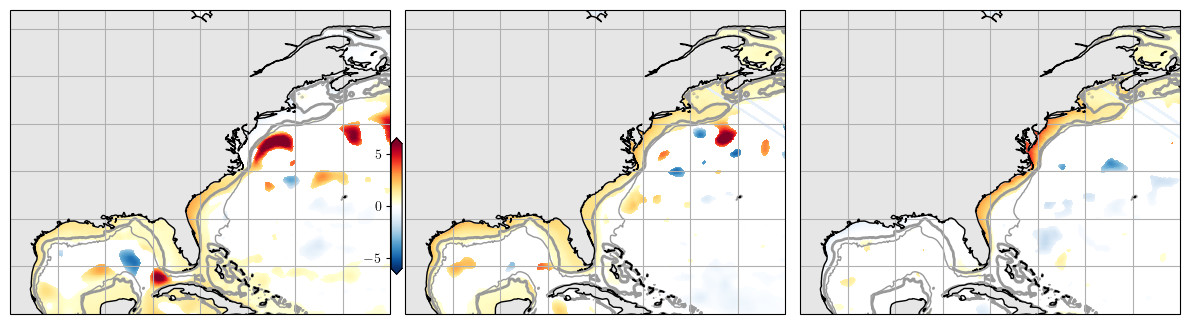

In [340]:
# da['time']=pcs[1].time
plot_ssh_reg(lfcs[1].T,da,da.TLONG.fillna(0),da.TLAT.fillna(0))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


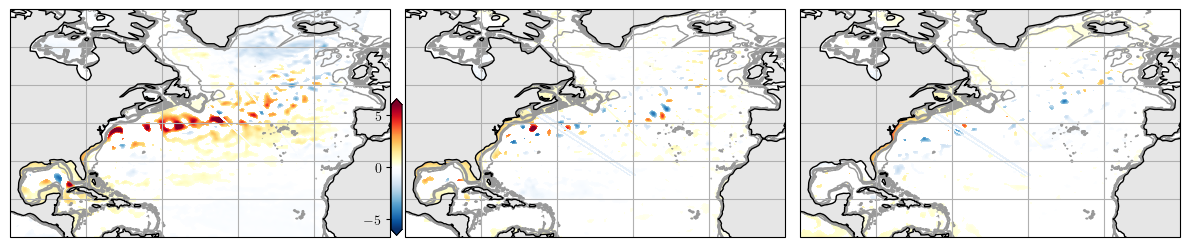

In [341]:
# da['time']=pcs[1].time
plot_ssh_reg(lfcs[1].T,da,da.TLONG.fillna(0),da.TLAT.fillna(0),False)

* All modes are mostly momentum forced
* Momentum forcing drives dipole mode and GS shift (local or remote forced?)
* East west dipole in SPG (wind forced signature of NAO?)

## Regression of full simulation modes on Buoyancy-forced SSH

In [342]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_b_det.nc')
da=ssh.ssh#.isel(time=slice(edgevals,-edgevals))
##bandpass

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


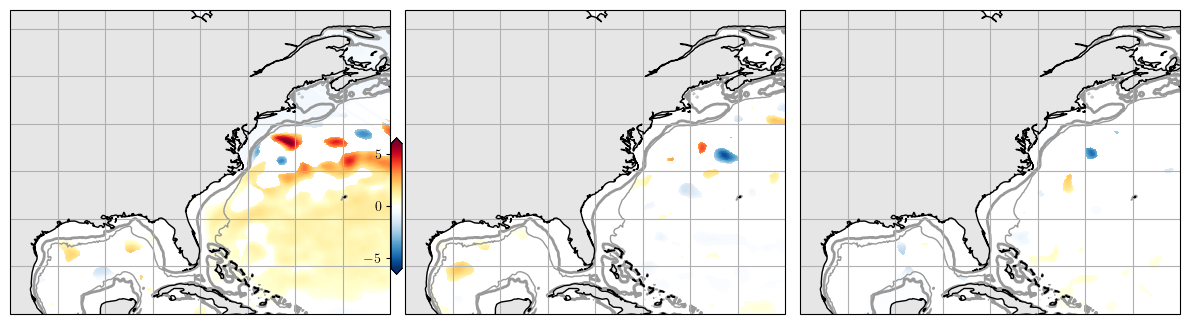

In [343]:
# da['time']=pcs[1].time
plot_ssh_reg(lfcs[1].T,da,da.TLONG.fillna(0),da.TLAT.fillna(0))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


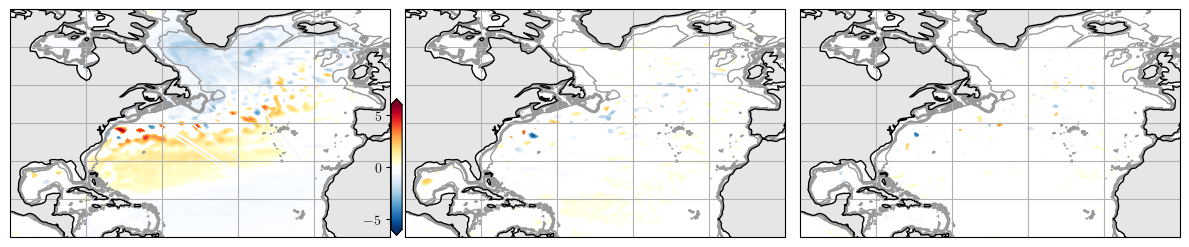

In [344]:
# da['time']=pcs[1].time
plot_ssh_reg(lfcs[1].T,da,da.TLONG.fillna(0),da.TLAT.fillna(0),False)

* NAO tripole assocaited with buoyancy forcings
* Mode 1 buoyancy forcing drives dipole but of limited amplitude at the coast
* Other modes have almost no buoyancy forced component

## Regression of full simulation modes on residual (Full-B-M)

In [1]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_det.nc')
ssh1 = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_m-r_det.nc')
ssh2 = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_b_det.nc')
da=ssh.ssh-ssh1.ssh-ssh2.ssh#.isel(time=slice(edgevals,-edgevals))
##bandpass

NameError: name 'xr' is not defined

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


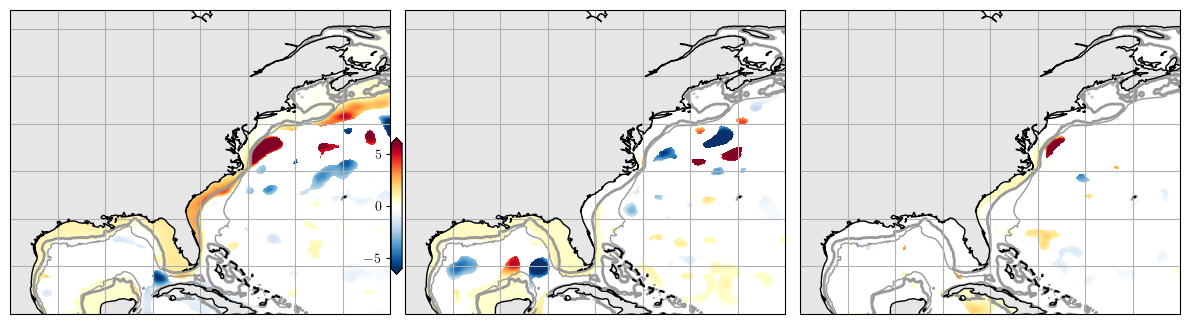

In [346]:
# da['time']=pcs[1].time
plot_ssh_reg(lfcs[1].T,da,da.TLONG.fillna(0),da.TLAT.fillna(0))

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


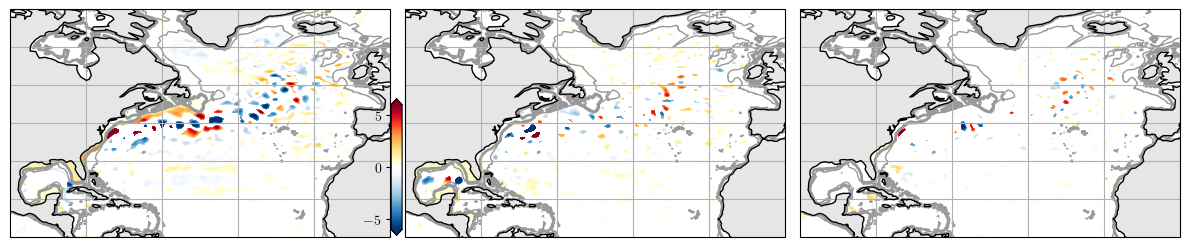

In [347]:
# da['time']=pcs[1].time
plot_ssh_reg(lfcs[1].T,da,da.TLONG.fillna(0),da.TLAT.fillna(0),False)

## M/B modes

/glade/derecho/scratch/clittle/tmp/ipykernel_96349/728892189.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
/glade/derecho/scratch/clittle/tmp/ipykernel_96349/728892189.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((4,3), (nsim, 1), colspan=2, rowspan=1)
/glade/derecho/scratch/clittle/tmp/ipykernel_96349/728892189.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = shortname[np.arange(0,

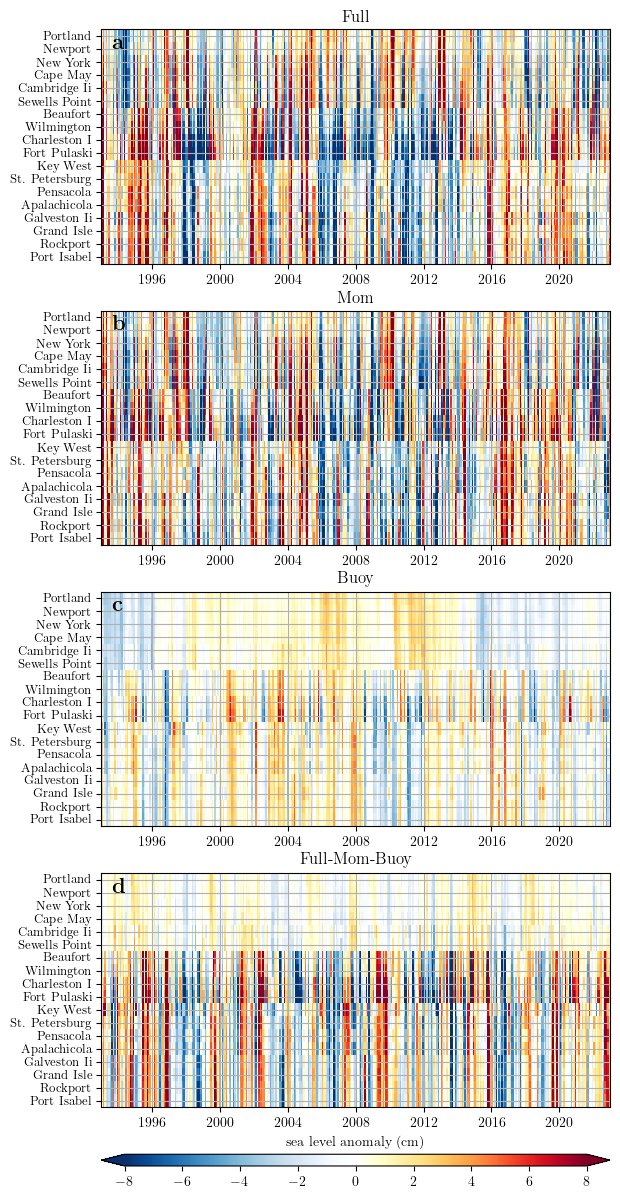

In [26]:
fig = plt.figure(figsize=(10,14))#, tight_layout=True)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

nsim=1
cmap = mycolors.blue2red_cmap(20)
# cmap='Spectral_r'
ylabspacing = 1

vmin = -8
vmax2 = -vmin

for nsim in np.arange(4):
    if nsim<1:
        plotvar=hr_tg
        titstr="Full"
    else:
        if nsim<2:
            plotvar=hr_m_tg
            titstr="Mom"
        else:
            if nsim<3:
                plotvar=hr_b_tg
                titstr="Buoy"
            else:
                plotvar=hr_tg-hr_m_tg-hr_b_tg
                titstr="Full-Mom-Buoy"

    ax1 = plt.subplot2grid((4,3), (nsim, 1), colspan=2, rowspan=1)

    filled1 = ax1.pcolormesh(
        xr_tg.time,
        np.arange(0, len(tgnames), 1),
        plotvar.T,
        vmin=vmin,
        vmax=vmax2,
        cmap=cmap,
        shading="nearest",
    )
    plt.figtext(0.02, .9, r"$\bf{" + panellabs[nsim] + '' "}$" , horizontalalignment='left', 
                    verticalalignment='bottom', fontsize=16, transform=ax1.transAxes)
    # ticks = np.arange(1.5, len(tgnames)+.5, ylabspacing)
# labels = tgnames[np.arange(1, len(tgnames), ylabspacing)]
# ax2.yaxis.set_ticks(ticks, labels=labels)    # plt.xlim([1000,1060])
    ticks = np.arange(0, len(tgnames), ylabspacing)
    if nsim<5:
        labels = shortname[np.arange(0, len(tgnames), ylabspacing)]
    else:
        labels = []
    ax1.yaxis.set_ticks(ticks, labels=labels, fontsize=9)
    plt.ylim([-.5, len(tgnames)-.5])
    plt.grid()
    pos = ax1.get_position()  # get the original position
    plt.title(titstr)
    
    if nsim>1:
        cbar_ax = fig.add_axes(
            [pos.x0, pos.y0-(pos.y1 - pos.y0)/4, (pos.x1-pos.x0), (pos.y1 - pos.y0)/20]
        )
        cbar = fig.colorbar(filled1, orientation="horizontal", cax=cbar_ax, extend="both",ticklocation='bottom')
        cbar.ax.set_title("sea level anomaly (cm)", rotation=0, size=10, weight="bold")
        cbar.ax.tick_params(labelsize=10)
plt.savefig('USEC_M_B_timeseries.png',
)

* substantial nonlinearity in the B/M combination south of Hatteras
* showing up in the smaller regression coefficients from the M run than full.
* Mechanism related to the combined influence on the GS detachment (where the coastal nonlinear signal originates)?

In [21]:
kwargs = dict(n_modes=len(xr_tg.T)-1,random_state=2)#, normalize=True)
expvar_eofs=[]
expvar_lfcs=[]
pcs=[]
eofs=[]
rec_eof_ts=[]
rec_lfp_ts=[]
lfcs=[]
lfps=[]
phases=[]
# real_ts=[]
cuts=[12,24,36]
cutoff=cuts[1]
truncation=3
nmodes=3
rec_eof=np.tile(xr_tg.values[np.newaxis,:, :]*0, [nmodes,1,1])
rec_lfp=np.tile(xr_tg.values[np.newaxis,:, :]*0, [nmodes,1,1])

for nsim in np.arange(3):
    if nsim<1:
        dain=hr_tg
    else:
        if nsim<2:
            dain=hr_m_tg
        else:
            dain=hr_b_tg
            
    lfc, lfp, weights, r, pvar, pc, eof, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts = tg_lfca(dain, cutoff, truncation)
    expvar_lfc = pvar_slow #fraction of total SSH variance
    expvar_eof = pvar
    
    for nmode in np.arange(nmodes):
        rec_eof[nmode,:,:]=np.outer(pc[:,nmode],eof[nmode,:])
        rec_lfp[nmode,:,:]=np.outer(lfc[:,nmode],lfp[nmode,:])
        
    expvar_eofs.append(expvar_eof)
    expvar_lfcs.append(expvar_lfc)
    # real_ts.append(dain)
    pcs.append(pc)
    lfcs.append(lfc)
    eofs.append(eof)
    lfps.append(lfp)
    rec_eof_ts.append(rec_eof)
    rec_lfp_ts.append(rec_lfp)

/glade/derecho/scratch/clittle/tmp/ipykernel_96349/1765057202.py:17: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend([],     # The line objects


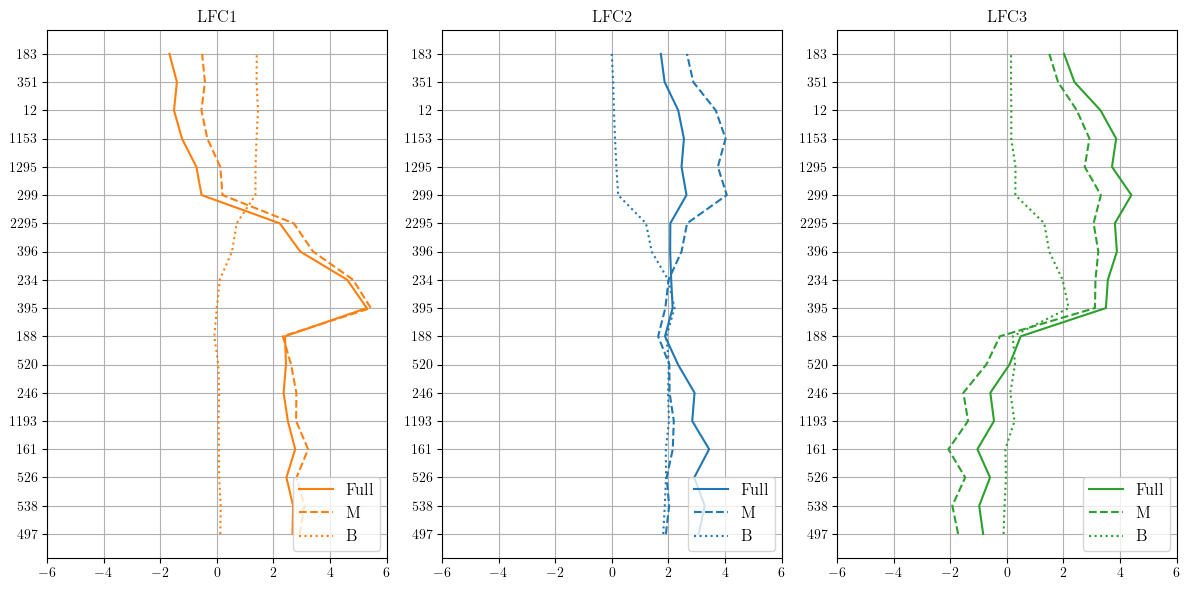

In [39]:
fig = plt.figure(figsize=(12,6), tight_layout=True)
for nmode in np.arange(3):
    ax = plt.subplot2grid((1,3), (0, nmode), colspan=1, rowspan=1)
    for nsim in np.arange(3):
        plt.plot(lfps[nsim][nmode,:],xr_tg.tgindex,color=cols[nmode+1],linestyle=lines[nsim])
    if nmode<1:
        titstr="LFC1"
    else:
        if nmode<2:
            titstr="LFC2"
        else:
            if nmode<3:
                titstr="LFC3"
    plt.xlim([-6,6])
    plt.title(titstr)
    plt.grid()
    plt.legend([],     # The line objects
       labels=["Full","M","B"],   # The labels for each line
       loc="lower right",   # Position of legend
       borderaxespad=0.4,    # Small spacing around legend box
       title="",
       fontsize=12,# Title for the legend
         )

## LR (decide whether to pursue resolution-sensitivity)

* Bring in LR comparison at end for discussion?
* HR is generally improved in representation of spatial structure relative to LR but still exhibits bias

In [77]:
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_det.nc')
da=ssh.ssh#.isel(time=slice(edgevals,-edgevals))
##bandpass

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


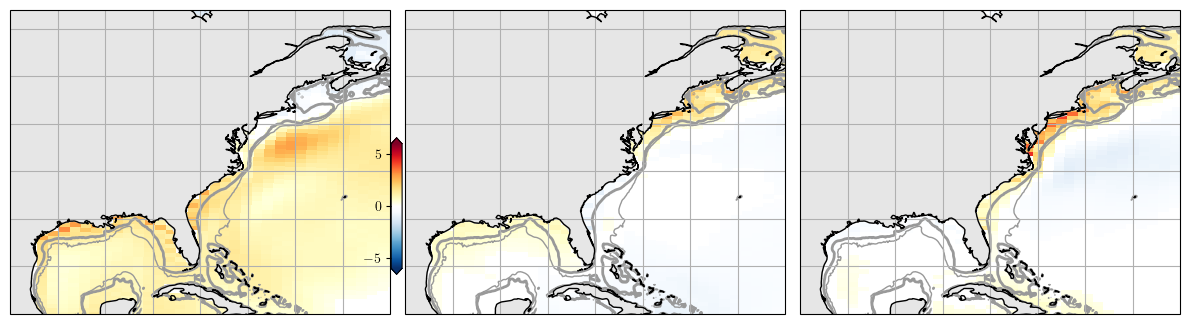

In [80]:
# da['time']=pcs[1].time
plot_ssh_reg(lfcs.T,da,da.TLONG.fillna(0),da.TLAT.fillna(0))

In [81]:
## LRs biggest difference is Mode 2, where south of hatteras coastal path is not permitted. others look similar

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


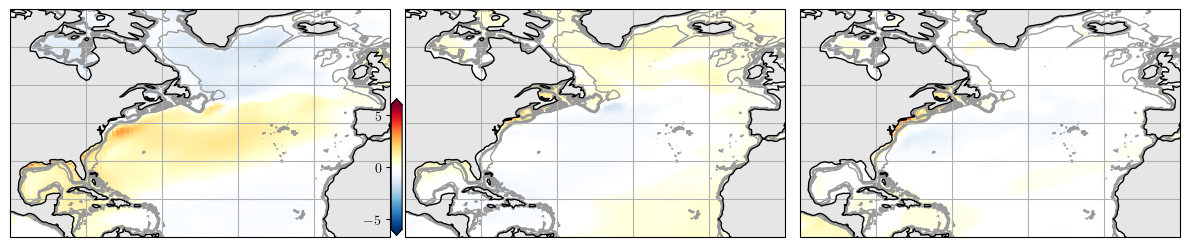

In [78]:
#detrend unfiltered
# da['time']=pcs[1].time
plot_ssh_reg(lfcs.T,da,da.TLONG.fillna(0),da.TLAT.fillna(0))

coherent connectivity still relevant over longer timescales (if LR considered)

Other thoughts/Discussion:
* Buoyancy forcing and sea level at basin scale is assocaited but is not the driver of coastal variability!
* Need to reconcile with ECCO studies! How does high resolution change these findings.
Coastal representation important!!
* Review Wang/ECCO paper  -- both Nantucket and Nantucket/Charleston and other
* Liping Zhang -- GFDL skill
* Detachment role
* Is there a lower-frequency common mode (dynamical or common forcing) alongcoast structure. What is AMOC role?